<a href="https://colab.research.google.com/github/devdevlope/Recruitment/blob/master/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle

from keras.models import load_model


In [ ]:
# Reading csv file with labels' names
# Loading two columns [0, 1] into Pandas dataFrame
labels = pd.read_csv('/content/label_names.csv')

# Check point
# Showing first 5 rows from the dataFrame
print(labels.head())
print()

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)



In [15]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
model = load_model('/content/model-23x23.h5')

# Loading mean image to use for preprocessing further
# Opening file for reading in binary mode
with open('/content/mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  # dictionary type
    
print(mean['mean_image_rgb'].shape)  # (3, 32, 32)

(3, 32, 32)


In [16]:
path_to_weights = '/content/yolov3.weights'
path_to_cfg = '/content/yolov3_ts_test.cfg'

# Loading trained YOLO v3 weights and cfg configuration file by 'dnn' library from OpenCV
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)


In [17]:
# Getting names of all YOLO v3 layers
layers_all = network.getLayerNames()

# Getting only detection YOLO v3 layers that are 82, 94 and 106
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]


In [18]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.2

# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generating colours for bounding boxes
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')


In [19]:
image_BGR = cv2.imread('/content/objects-to-detect.jpg')
print('Image shape:', image_BGR.shape)  # tuple of (731, 1092, 3)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Check point
# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))

Image shape: (852, 1200, 3)
Image height=852 and width=1200


Total amount of time 1.84069 seconds


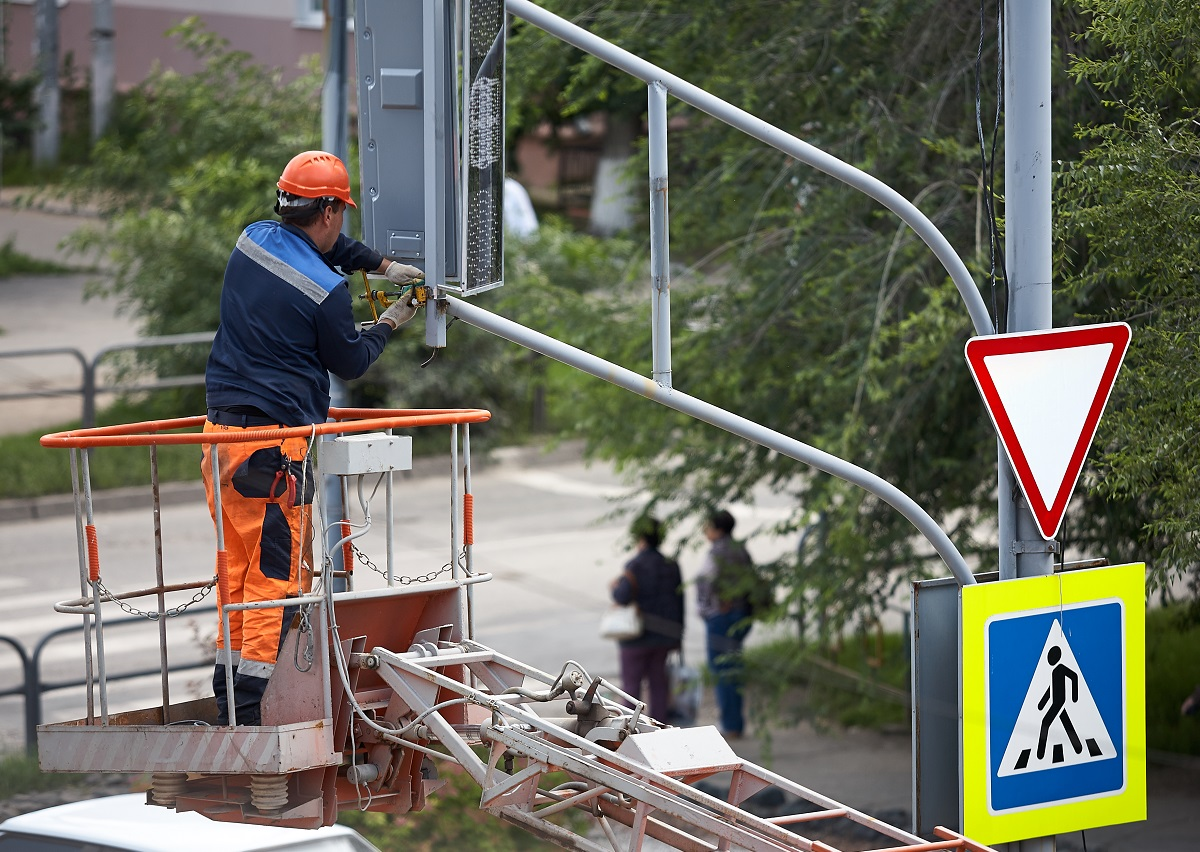

In [24]:
from google.colab.patches import cv2_imshow
t = 0

# Blob from current frame
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Time
t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial frame size
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Getting top left corner coordinates
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                

# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
        # Cut fragment with Traffic Sign
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        # print(c_ts.shape)
            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            # plt.imshow(blob_ts[0, :, :, :])
            # plt.show()

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = model.predict(blob_ts)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)
            print(labels['SignName'][prediction])


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()
            
            # Green BGR
            colour_box_current = [0, 255, 61]
            
            # Yellow BGR
#             colour_box_current = [0, 255, 255]

            # Drawing bounding box on the original current frame
            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 6)

#             # Preparing text with label and confidence for current bounding box
#             text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
#                                                    confidences[i])
            
#             # Putting text with label and confidence on the original image
#             cv2.putText(image_BGR, text_box_current, (x_min, y_min - 15),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
            
            if prediction == 5:
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('Speed limit 60', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
                
            elif prediction == 9:            
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('No overtaking', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min + box_height + 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)

#             elif prediction == 17:            
#                 # Preparing text with label and confidence for current bounding box
#                 text_box_current = '{}: {:.4f}'.format('No entry', confidences[i])

#                 # Putting text with label and confidence on the original image
#                 cv2.putText(image_BGR, text_box_current, (x_min - 170, y_min - 15),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
                
                
# Saving image
cv2_imshow(image_BGR)